In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# IMPT: make shortcut of the BT4012 Project folder inside your google drive so the stuff below works
drive.mount("/content/drive")
trainData = pd.read_csv("/content/drive/My Drive/BT4012 Project/fraudTrain.csv")
testData = pd.read_csv("/content/drive/My Drive/BT4012 Project/fraudTest.csv")
allData = pd.concat([trainData, testData])

Mounted at /content/drive


In [3]:
def age_group(row):
    rows = row["age"]
    if rows <20:
        return "less than 20"
    elif rows >=20 and rows<30:
        return "20 to 30"
    elif rows >=30 and rows<40:
        return "30 to 40"
    elif rows >=40 and rows<50:
        return "40 to 50"
    elif rows >=50 and rows<60:
        return "50 to 60"
    elif rows >=60 and rows<70:
        return "60 to 70"
    elif rows >=70 and rows<80:
        return "70 to 80"
    elif rows >=80 and rows<90:
        return "80 to 90"
    else:
        return "greater than 90"

In [4]:
from sklearn.model_selection import train_test_split

# print(allData.corr())

# age grp
allData["age"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).year-pd.DatetimeIndex(allData["dob"]).year
allData["age_group"] = allData.apply(age_group,axis=1)

# trans times / age
allData["trans_hour"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).hour
allData["trans_yrmth"] = pd.DatetimeIndex(allData['trans_date_trans_time']).strftime('%Y-%m')
allData["weekday"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).weekday
allData["date"] = pd.to_datetime(allData['trans_date_trans_time']).dt.date

# drop redundant index column
allData.drop(labels="Unnamed: 0", axis=1, inplace=True)

# calculating the distance between the merchant location and transaction location
allData["latitude_difference"] = abs(allData["lat"]-allData["merch_lat"])
allData["longitude_difference"] = abs(allData["long"]-allData["merch_long"])

# it is estimated that difference between each degree of longitude and lattitude is approximately 69 miles which is 110 km
# applying pythogoras theorem
allData["distance"] = np.sqrt(pow(allData["latitude_difference"]*110,2)+pow(allData["longitude_difference"]*110,2))
allData['distance'].describe()

allData.category = allData.category.astype("category")
allData.gender = allData.gender.astype("category")
allData.state = allData.state.astype("category")
allData.age_group = allData.age_group.astype("category")
allData.trans_yrmth = allData.trans_yrmth.astype("category")
allData.weekday = allData.weekday.astype("category")
allData.job = allData.job.astype("category")
allData.city = allData.city.astype("category")
allData.is_fraud = allData.is_fraud.astype("category")
allData.trans_hour = allData.trans_hour.astype("category")

#can ignore others, just use train, validation, test
train, others = train_test_split(allData, test_size=0.2, random_state=4012)
del(allData)
validation, test = train_test_split(others, test_size=0.5, random_state=4012)
del(others)

onlyFraud = train[train.is_fraud == 1]
noFraud = train[train.is_fraud != 1]

print(onlyFraud)

       trans_date_trans_time            cc_num  \
288598   2019-05-21 23:40:29  6011438889172900   
644699   2019-10-01 01:45:49   346208242862904   
366597   2019-06-19 01:11:01  6506116513503136   
621562   2019-09-21 17:41:09  3565943051129759   
10057    2019-01-07 04:34:48  3597980945245815   
...                      ...               ...   
205282   2019-04-15 03:05:13  3548710338694745   
389704   2020-11-21 03:17:38    30235268718158   
204807   2020-09-01 01:10:19  4003989662068504   
93343    2019-02-24 22:33:25   180036456789979   
351029   2019-06-14 00:17:50  6011948324228984   

                                  merchant       category     amt      first  \
288598                fraud_Abbott-Steuber  personal_care   20.17    Allison   
644699                   fraud_Collier Inc    grocery_net   10.54    Tabitha   
366597               fraud_Dooley-Thompson       misc_net  773.63   Kimberly   
621562                     fraud_Lynch Ltd   shopping_pos  905.66      David   

In [5]:
train.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
train.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

validation.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
validation.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

test.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
test.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

train

,category,amt,gender,city,state,job,is_fraud,age_group,trans_hour,trans_yrmth,weekday,distance
1089385,shopping_net,9.11,M,Pembroke,NC,Hospital doctor,0,60 to 70,7,2020-03,6,88.270416
396245,gas_transport,75.57,F,Centerview,MO,Electronics engineer,0,30 to 40,1,2019-06,6,117.115063
816379,misc_net,390.37,M,Oakland,TN,Furniture conservator/restorer,0,20 to 30,5,2019-12,6,56.383604
476241,shopping_pos,96.55,F,Lakeport,CA,Podiatrist,0,40 to 50,12,2020-12,0,108.142655
567642,kids_pets,13.78,M,San Antonio,TX,Exhibition designer,0,40 to 50,20,2019-08,3,98.590270
...,...,...,...,...,...,...,...,...,...,...,...,...
1286615,misc_pos,6.88,F,Sutherland,NE,Insurance broker,0,30 to 40,23,2020-06,1,62.997041
926319,shopping_net,98.85,F,Steuben,ME,Make,0,60 to 70,3,2020-01,3,122.501992
83164,misc_pos,10.48,F,Tulsa,OK,Bookseller,0,50 to 60,9,2020-07,0,82.202315
301454,travel,6.45,F,Allentown,PA,"Scientist, research (maths)",0,20 to 30,23,2019-05,6,22.751546


In [6]:
fullData = pd.concat([train, test])
fullData.shape

(1667155, 12)

In [7]:
catVars = ['category', 'gender', 'city', 'state', 'job', 'age_group', 'trans_yrmth']

In [8]:
#city and job too many variables prob need to reduce it somehow by grping or smthing
for x in fullData[catVars].columns:
  n = fullData[x].nunique()
  print(f'{x} has {n} unique values')

category has 14 unique values
gender has 2 unique values
city has 906 unique values
state has 51 unique values
job has 497 unique values
age_group has 9 unique values
trans_yrmth has 24 unique values


In [9]:
fullData.drop(columns = {'city', 'job'}, inplace = True)
# fullData.drop(columns = {'city'}, inplace = True)

In [10]:
catVars2 = ['category', 'gender', 'state', 'age_group', 'trans_yrmth']
# catVars2 = ['category', 'gender', 'age_group', 'trans_yrmth', 'state', 'job']

In [11]:
dfEncode = pd.get_dummies(fullData, columns = catVars2)

In [12]:
xCols = dfEncode.columns.drop('is_fraud')
X = dfEncode[xCols]
y = dfEncode['is_fraud']

In [13]:
X_train, X_other, Y_train, Y_other = train_test_split(X, y, test_size=0.2, random_state=4012)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_other, Y_other, test_size=0.5, random_state=4012)

In [14]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

numeric_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric_transformer", numeric_transformer, make_column_selector(dtype_exclude="category")),
    ("categorical_transformer", categorical_transformer, make_column_selector(dtype_include="category"))
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logistic_regression", LogisticRegression(class_weight="balanced", n_jobs=-1, random_state=4012))
])

time_start = time.perf_counter()

pipeline.fit(X_train, Y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(pipeline.predict(X_validation))
y_pred

# Track the performance of various models
performance_tracker = pd.DataFrame(columns=["Model Name", "Training Time", "Accuracy", "Recall", "Precision", "F1", "ROC AUC"])
performance_tracker.loc["Logistic Regression"] = ["Logistic Regression", training_time, accuracy_score(Y_validation, y_pred), recall_score(Y_validation, y_pred), precision_score(Y_validation, y_pred), f1_score(Y_validation, y_pred), roc_auc_score(Y_validation, y_pred)]
performance_tracker

,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
Logistic Regression,Logistic Regression,53.772368,0.875692,0.912485,0.036489,0.070172,0.893994


In [16]:
numeric_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric_transformer", numeric_transformer, make_column_selector(dtype_exclude="category")),
    ("categorical_transformer", categorical_transformer, make_column_selector(dtype_include="category"))
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logistic_regression", LogisticRegression(class_weight="balanced", n_jobs=-1, random_state=4012, C=0.01))
])

time_start = time.perf_counter()

pipeline.fit(X_train, Y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(pipeline.predict(X_validation))
y_pred

# Track the performance of various models
performance_tracker.loc["Logistic Regression 2"] = ["Logistic Regression 2", training_time, accuracy_score(Y_validation, y_pred), recall_score(Y_validation, y_pred), precision_score(Y_validation, y_pred), f1_score(Y_validation, y_pred), roc_auc_score(Y_validation, y_pred)]
performance_tracker

,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
Logistic Regression,Logistic Regression,53.772368,0.875692,0.912485,0.036489,0.070172,0.893994
Logistic Regression 2,Logistic Regression 2,69.819268,0.876292,0.912485,0.036660,0.070489,0.894295


In [17]:
numeric_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric_transformer", numeric_transformer, make_column_selector(dtype_exclude="category")),
    ("categorical_transformer", categorical_transformer, make_column_selector(dtype_include="category"))
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logistic_regression", LogisticRegression(class_weight="balanced", n_jobs=-1, random_state=4012, C=0.002))
])

time_start = time.perf_counter()

pipeline.fit(X_train, Y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(pipeline.predict(X_validation))
y_pred

# Track the performance of various models
performance_tracker.loc["Logistic Regression 3"] = ["Logistic Regression 3", training_time, accuracy_score(Y_validation, y_pred), recall_score(Y_validation, y_pred), precision_score(Y_validation, y_pred), f1_score(Y_validation, y_pred), roc_auc_score(Y_validation, y_pred)]
performance_tracker

,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
Logistic Regression,Logistic Regression,53.772368,0.875692,0.912485,0.036489,0.070172,0.893994
Logistic Regression 2,Logistic Regression 2,69.819268,0.876292,0.912485,0.036660,0.070489,0.894295
Logistic Regression 3,Logistic Regression 3,57.207516,0.878931,0.912485,0.037432,0.071915,0.895622


In [18]:
numeric_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric_transformer", numeric_transformer, make_column_selector(dtype_exclude="category")),
    ("categorical_transformer", categorical_transformer, make_column_selector(dtype_include="category"))
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logistic_regression", LogisticRegression(class_weight="balanced", n_jobs=-1, random_state=4012, C=0.002, solver='saga'))
])

time_start = time.perf_counter()

pipeline.fit(X_train, Y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(pipeline.predict(X_validation))
y_pred

# Track the performance of various models
performance_tracker.loc["Logistic Regression 4"] = ["Logistic Regression 4", training_time, accuracy_score(Y_validation, y_pred), recall_score(Y_validation, y_pred), precision_score(Y_validation, y_pred), f1_score(Y_validation, y_pred), roc_auc_score(Y_validation, y_pred)]
performance_tracker

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
Logistic Regression,Logistic Regression,53.772368,0.875692,0.912485,0.036489,0.070172,0.893994
Logistic Regression 2,Logistic Regression 2,69.819268,0.876292,0.912485,0.036660,0.070489,0.894295
Logistic Regression 3,Logistic Regression 3,57.207516,0.878931,0.912485,0.037432,0.071915,0.895622
Logistic Regression 4,Logistic Regression 4,335.579036,0.878685,0.915986,0.037492,0.072035,0.897239


In [19]:
numeric_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric_transformer", numeric_transformer, make_column_selector(dtype_exclude="category")),
    ("categorical_transformer", categorical_transformer, make_column_selector(dtype_include="category"))
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logistic_regression", LogisticRegression(class_weight="balanced", n_jobs=-1, random_state=4012, C=0.002, solver='saga', penalty='elasticnet', l1_ratio=0.1))
])

time_start = time.perf_counter()

pipeline.fit(X_train, Y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(pipeline.predict(X_validation))
y_pred

# Track the performance of various models
performance_tracker.loc["Logistic Regression 5"] = ["Logistic Regression 5", training_time, accuracy_score(Y_validation, y_pred), recall_score(Y_validation, y_pred), precision_score(Y_validation, y_pred), f1_score(Y_validation, y_pred), roc_auc_score(Y_validation, y_pred)]
performance_tracker

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
Logistic Regression,Logistic Regression,53.772368,0.875692,0.912485,0.036489,0.070172,0.893994
Logistic Regression 2,Logistic Regression 2,69.819268,0.876292,0.912485,0.036660,0.070489,0.894295
Logistic Regression 3,Logistic Regression 3,57.207516,0.878931,0.912485,0.037432,0.071915,0.895622
Logistic Regression 4,Logistic Regression 4,335.579036,0.878685,0.915986,0.037492,0.072035,0.897239
Logistic Regression 5,Logistic Regression 5,407.777911,0.878559,0.917153,0.037498,0.072051,0.897756


In [20]:
numeric_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric_transformer", numeric_transformer, make_column_selector(dtype_exclude="category")),
    ("categorical_transformer", categorical_transformer, make_column_selector(dtype_include="category"))
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logistic_regression", LogisticRegression(class_weight="balanced", n_jobs=-1, random_state=4012, C=0.002, solver='saga', penalty='elasticnet', l1_ratio=0.9))
])

time_start = time.perf_counter()

pipeline.fit(X_train, Y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(pipeline.predict(X_validation))
y_pred

# Track the performance of various models
performance_tracker.loc["Logistic Regression 6"] = ["Logistic Regression 6", training_time, accuracy_score(Y_validation, y_pred), recall_score(Y_validation, y_pred), precision_score(Y_validation, y_pred), f1_score(Y_validation, y_pred), roc_auc_score(Y_validation, y_pred)]
performance_tracker

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
Logistic Regression,Logistic Regression,53.772368,0.875692,0.912485,0.036489,0.070172,0.893994
Logistic Regression 2,Logistic Regression 2,69.819268,0.876292,0.912485,0.036660,0.070489,0.894295
Logistic Regression 3,Logistic Regression 3,57.207516,0.878931,0.912485,0.037432,0.071915,0.895622
Logistic Regression 4,Logistic Regression 4,335.579036,0.878685,0.915986,0.037492,0.072035,0.897239
Logistic Regression 5,Logistic Regression 5,407.777911,0.878559,0.917153,0.037498,0.072051,0.897756
Logistic Regression 6,Logistic Regression 6,469.488155,0.876988,0.915986,0.036992,0.071112,0.896386


In [21]:
numeric_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric_transformer", numeric_transformer, make_column_selector(dtype_exclude="category")),
    ("categorical_transformer", categorical_transformer, make_column_selector(dtype_include="category"))
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logistic_regression", LogisticRegression(class_weight="balanced", n_jobs=-1, random_state=4012, C=0.002, solver='saga', penalty='elasticnet', l1_ratio=0.5))
])

time_start = time.perf_counter()

pipeline.fit(X_train, Y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(pipeline.predict(X_validation))
y_pred

# Track the performance of various models
performance_tracker.loc["Logistic Regression 7"] = ["Logistic Regression 7", training_time, accuracy_score(Y_validation, y_pred), recall_score(Y_validation, y_pred), precision_score(Y_validation, y_pred), f1_score(Y_validation, y_pred), roc_auc_score(Y_validation, y_pred)]
performance_tracker

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
Logistic Regression,Logistic Regression,53.772368,0.875692,0.912485,0.036489,0.070172,0.893994
Logistic Regression 2,Logistic Regression 2,69.819268,0.876292,0.912485,0.036660,0.070489,0.894295
Logistic Regression 3,Logistic Regression 3,57.207516,0.878931,0.912485,0.037432,0.071915,0.895622
Logistic Regression 4,Logistic Regression 4,335.579036,0.878685,0.915986,0.037492,0.072035,0.897239
Logistic Regression 5,Logistic Regression 5,407.777911,0.878559,0.917153,0.037498,0.072051,0.897756
Logistic Regression 6,Logistic Regression 6,469.488155,0.876988,0.915986,0.036992,0.071112,0.896386
Logistic Regression 7,Logistic Regression 7,407.170081,0.877803,0.919487,0.037362,0.071806,0.898537


In [22]:
numeric_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric_transformer", numeric_transformer, make_column_selector(dtype_exclude="category")),
    ("categorical_transformer", categorical_transformer, make_column_selector(dtype_include="category"))
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logistic_regression", LogisticRegression(class_weight="balanced", n_jobs=-1, random_state=4012, C=0.0001, solver='newton-cg', penalty='l2'))
])

time_start = time.perf_counter()

pipeline.fit(X_train, Y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(pipeline.predict(X_validation))
y_pred

# Track the performance of various models
performance_tracker.loc["Logistic Regression after GS"] = ["Logistic Regression after GS", training_time, accuracy_score(Y_validation, y_pred), recall_score(Y_validation, y_pred), precision_score(Y_validation, y_pred), f1_score(Y_validation, y_pred), roc_auc_score(Y_validation, y_pred)]
performance_tracker

,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
Logistic Regression,Logistic Regression,53.772368,0.875692,0.912485,0.036489,0.070172,0.893994
Logistic Regression 2,Logistic Regression 2,69.819268,0.876292,0.912485,0.036660,0.070489,0.894295
Logistic Regression 3,Logistic Regression 3,57.207516,0.878931,0.912485,0.037432,0.071915,0.895622
Logistic Regression 4,Logistic Regression 4,335.579036,0.878685,0.915986,0.037492,0.072035,0.897239
Logistic Regression 5,Logistic Regression 5,407.777911,0.878559,0.917153,0.037498,0.072051,0.897756
Logistic Regression 6,Logistic Regression 6,469.488155,0.876988,0.915986,0.036992,0.071112,0.896386
Logistic Regression 7,Logistic Regression 7,407.170081,0.877803,0.919487,0.037362,0.071806,0.898537
Logistic Regression after GS,Logistic Regression after GS,139.459382,0.914675,0.826138,0.047890,0.090531,0.870635


In [24]:
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
X_train, Y_train = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'saga']
penalty = ['l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01, 0.001, 0.0001]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.976667 using {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.955333 (0.031277) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.954000 (0.033126) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.952667 (0.030324) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.956667 (0.029702) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
0.956000 (0.031581) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.954667 (0.031805) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.952667 (0.030324) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.955333 (0.029522) with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
840 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solv

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(Y_validation,y_pred))
print("True Negative      False Positive" + "\n" + "False Negative     True Positive")
print('\n')
print(classification_report(Y_validation,y_pred))

[[151782  14076]
 [   149    708]]
True Negative      False Positive
False Negative     True Positive


              precision    recall  f1-score   support

           0       1.00      0.92      0.96    165858
           1       0.05      0.83      0.09       857

    accuracy                           0.91    166715
   macro avg       0.52      0.87      0.52    166715
weighted avg       0.99      0.91      0.95    166715



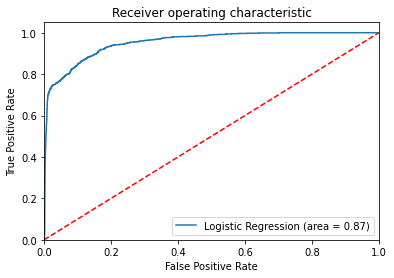

In [71]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_validation, pipeline.predict(X_validation))
fpr, tpr, thresholds = roc_curve(Y_validation, pipeline.predict_proba(X_validation)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).